## **Implementing Skip-gram Word Embeddings in PyTorch**

Arguably the most crucial step in NLP is to convert words and sentences into a form that neural networks can work with - a vector of numbers.  

In this part of Week 2's graded assignment, you will implement the Skip-gram word embedding model for a given set of documents (sentences in our case). You will also observe the trends and similarities between the vector representations of different words.

### **Note:**
**You are to only write/modify the code in between consecutive `# <START>` and `# <END>` comments. DO NOT modify other parts of the notebook, your assignments will not be graded otherwise.**

```python
"Don't modify any code here"

# < START >
"YOUR CODE GOES HERE!"
# < END >

"Don't modify any code here"
```



## **Import the Libraries**

Run the cell below to import all the necessary libraries for training and using the skip-gram model.

Some of the important ones
- [PyTorch](https://pytorch.org/docs/stable/index.html) for tensors and training the neural network
- NLTK (Natural Language ToolKit) for text pre-processing (specifically, stop-word removal and tokenization).
- `re` module for RegEx
- [Pandas](https://pandas.pydata.org/docs/reference/index.html) for data manipulation
- scikit-learn for some implementations of involved matrix maths

In [ ]:
# PyTorch
import torch
import torch.nn as nn

torch.manual_seed(10)
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")

# NLTK (Natural Language ToolKit)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.metrics.pairwise import cosine_similarity

# Graphing
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Preprocessing**
Before you train your model on a body of text, it has to be split into individual _"words"_, that have been reduced to their simplest form. This is done in pre-processing, and involves the steps shows below:
![picture](https://d2mk45aasx86xg.cloudfront.net/Natural_language_processing_pipeline_e3608ff95c.webp)

**In this section, you will implement a simplified pre-processing pipeline for your body of text.** We will not be dealing with the last two steps (dependency parsing, POS tagging) in this assignment.

### **Corpus and Sentence Segmentation**
According to Google,
>**Corpus**  (*noun*)  
a collection of written or spoken material in machine-readable form, assembled for the purpose of linguistic research.

Simply, a corpus is a collection of text used to train a neural network. Usually the text you have is a long string that you would need to split into individual sentences, but for this assignment this step has already been done.  
Run this cell to intialize `corpus`.



In [ ]:
corpus = [
    'Drink milk',
    'Drink cold water',
    'Drink cold cola',
    'He is drinking juice',
    'Drinking cola and juice',
    'Eat roti for lunch',
    'Eat mango',
    'Eating a cherry',
    'Eating an apple',
    'Juice with sugar',
    'Cola with sugar',
    'Mango is a fruit',
    'Apple is a fruit',
    'Cherry is a fruit',
    'Berlin is in Germany',
    'Boston is in USA',
    'Mercedes is a car',
    'Mercedes is from Germany',
    'Ford is a car',
    'Ford is a car from USA',
]

### **Tokenization**
Tokenization is done to break down the text into smaller, more manageable units. This can be achieved by simply breaking them down into individual words, although most tokenizers are a bit more complex.

### **Stemming**
Stemming is a natural language processing technique that is used to reduce words to their base form, also known as the root form. The process of stemming is used to normalize text and make it easier to process.  This is usually done by removing prefixes and suffixes added to the word.  
These algorithms are usually much simpler and faster than **lemmetization**, but don't always produce accurate results, as we will see soon.

### **Removing stop words**
Stop words are common words in English that do not contribute any real meaning to the sentence. Removing these stop words speeds up processing and allows the application to focus on the more important words instead.

In [ ]:
# Some of the stopwords
print(" ".join(stopwords.words('english')[:20])," ".join(stopwords.words('english')[45:60]))

i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his is are was were be been being have has had having do does did doing


Your corpus has been chosen in such a way that it is mostly cleaned up, but still contains:
- a few verbs in their -ing form
- a significant amount of stop-words

Write a `preprocess` function that takes the corpus as an argument, and outputs a list of lists, where **each inner list representing the corresponing sentence in tokenized form (using NLTK)**, and with:
- **the stop words removed**
- **"-ing" form verbs reduced to their normal forms**

using string methods and RegEx (you are not obligated to use both though, feel free to implement it with just one).

_Note: **We do not want you to implement a stemmer that converts all -ing form verbs in English to the correct root verb.** Observe that the given corpus only contains verbs that have been converted to their continuous form simply by suffixing "ing"_
<details>
  <summary>Hint (reg NLTK)</summary>
The only function you really need from NLTK is <a href="https://www.nltk.org/api/nltk.tokenize.word_tokenize.html"><code>nltk.tokenize.word_tokenize()</code></a>
</details>
<details>
  <summary>Why has the stop words list been converted to a set?</summary>
When using the <code>in</code> operator to check for the existence of an element in a list, Python traverses the list checking each element one-by-one. As such, the larger the list the longer it takes.<br>  
However, sets are unordered collections implemented using hash maps. What this means is that to check if a set has a certain value, all Python has to do is pass that value in a "function" that outputs the location at which the set would store that value if it did contain it. As such, no matter how big the set is, it takes the same amount of time to check for existence.
</details>

In [ ]:
# The list of stopwords has been coverted into a set, making it faster to check if a given word is in it
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    result = []
    for i in corpus:

      # <START>
      i=i.lower()
      word_tokens = nltk.tokenize.word_tokenize(i)
      out = [w[:-3] if w[-3:]=='ing' else w for w in word_tokens if w not in stop_words]
      # <END>
      result.append(out)
    return result

# Test for if the function behaves as expected, notice the last test case and expected output
test_preprocess = preprocess(['Python is a language','The cake is a lie','He is doing practice','Writing code'])
assert test_preprocess == [['python', 'language'],['cake', 'lie'],['practice'],['writ', 'code']]

As you can see in the assertion test, the extremely simple stemmer is not going to be able to account for different grammar rules. The average stemmer is many times more intricate, but still often generates non-sense words.

The common alternative to this is to use **lemmetization**, which is a slower but more pedantic method that always produces sensible words, but may not reduce words to the same initial root word if they have become too different.

Lemmetization and stemming are often used together, to complement each other.

Now use the `preprocess` function on the given corpus.

In [ ]:
corpus = preprocess(corpus)
corpus

[['drink', 'milk'],
 ['drink', 'cold', 'water'],
 ['drink', 'cold', 'cola'],
 ['drink', 'juice'],
 ['drink', 'cola', 'juice'],
 ['eat', 'roti', 'lunch'],
 ['eat', 'mango'],
 ['eat', 'cherry'],
 ['eat', 'apple'],
 ['juice', 'sugar'],
 ['cola', 'sugar'],
 ['mango', 'fruit'],
 ['apple', 'fruit'],
 ['cherry', 'fruit'],
 ['berlin', 'germany'],
 ['boston', 'usa'],
 ['mercedes', 'car'],
 ['mercedes', 'germany'],
 ['ford', 'car'],
 ['ford', 'car', 'usa']]

## **Building the vocabulary**

Before we start representing words as vectors, we must first identify how many **unique** words our corpus contains. Complete the below function to create a dictionary of words `vocabulary`. This will contain all the words from the corpus our neural network will be trained on as keys, and a unique incrementing ID for each word, starting from `0` as the corresponding value.

_Remember: Dicts are key-value collections_
```python
 dict = {'key': value}
 dict['new key'] = new_value
 ```

In [ ]:
def create_vocabulary(corpus):
    # Creates a dictionary with all unique words in corpus with id
    vocabulary = {}
    id = 0
    # <START>
    for sent in corpus:
      for w in sent:
        if w not in vocabulary:
          vocabulary[w]=id
          id+=1

    # <END>
    return vocabulary
# Test for create_vocabulary
assert(create_vocabulary([['words','are','many'],['many','words','exist'],['are','we','exist']]) == {'words': 0, 'are': 1, 'many': 2, 'exist': 3, 'we': 4})
vocabulary = create_vocabulary(corpus)
vocabulary

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'roti': 7,
 'lunch': 8,
 'mango': 9,
 'cherry': 10,
 'apple': 11,
 'sugar': 12,
 'fruit': 13,
 'berlin': 14,
 'germany': 15,
 'boston': 16,
 'usa': 17,
 'mercedes': 18,
 'car': 19,
 'ford': 20}

## **Creating the dataset**

Now we analyse each sentence in the corpus and create a dataset that holds each `(word, neighbour)` pair.

![Neighbor pairing for bi-gram (n=2)](https://miro.medium.com/v2/resize:fit:552/format:webp/1*jkxbwD55_8M3XBRb1bGm7A.png "Neighbor pairing for bi-gram (n=2)")
>_The word highlighted in yellow is the source word and the words highlighted in green are its neighboring words._

Complete the function `prepare_neighbour_set` that takes the tokenized `corpus` and an optional integer `n_gram`, and returns a Pandas DataFrame `result` that contains two columns, `Input` and `Output`. Input column contains each source word, and Output column contains the neighbours of the source word, within a `n_gram` range on either side.

$$
\text{['this', 'is', 'a', 'sentence']  (n_gram = 1)}
$$

$$
\newcommand\T{\Rule{0pt}{1em}{.3em}}
\begin{array}{|c|c|}
\hline Input & Output \T \\\hline
  this \T & is \\\hline
  is \T & this \\\hline
  is \T & a \\\hline
  a \T & is \\\hline
  a \T & sentence \\\hline
  sentence \T & a \\\hline
\end{array}
$$

Remember to account for the corner cases, where the Input word may not have enough neighbours on both sides.

<details>
  <summary>Hint</summary>
  To add a row to the DataFrame, use the following code
  <code>result = result.append(row, ignore_index = True)</code>
  <br>
  The row dataframe should have the same columns as the result dataframe.
  <br>
  This is a deprecated function, but it is apt for the current scenario so feel free to use it
</details>

In [ ]:
def prepare_neighbour_set(corpus, n_gram = 1):
    # Creates a dataset with Input column and Output column for neighboring words.
    # The number of neighbors = n_gram*2
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    print(corpus)
    for sentence in corpus:
      for i,word in enumerate(sentence):

          # <START>
           # look back
        if i>0 and i<len(sentence)-1:
          row_1 = pd.Series({'Input': sentence[i], 'Output': sentence[i-1] })
          row_2 = pd.Series({'Input': sentence[i], 'Output': sentence[i+1] })
          result = result.append(row_1, ignore_index = True)
          result = result.append(row_2, ignore_index = True)

           # look forward
        elif i==0:
          row = pd.Series({'Input': sentence[i], 'Output': sentence[i+1] })
          result = result.append(row, ignore_index = True)
        else:
          row = pd.Series({'Input': sentence[i], 'Output': sentence[i-1] })
          result = result.append(row, ignore_index = True)



          # <END>

    return result

In [ ]:
# Test to check prepare_neighbour_set. The rows are
# sorted to make the assertion order-insensitive
test_neighbour = prepare_neighbour_set([['this','is','a','sentence']]).sort_values(by=['Input','Output'])

test_neighbour_expected = pd.DataFrame({
    'Input': ['this','is','is','a','a','sentence'],
    'Output': ['is','this','a','is','sentence','a']
}).sort_values(by=['Input','Output'])

assert test_neighbour.equals(test_neighbour_expected)

# Initialize neighbour words dataset for corpus
train_emb = prepare_neighbour_set(corpus, n_gram = 2)
train_emb.head()

[['this', 'is', 'a', 'sentence']]
[['drink', 'milk'], ['drink', 'cold', 'water'], ['drink', 'cold', 'cola'], ['drink', 'juice'], ['drink', 'cola', 'juice'], ['eat', 'roti', 'lunch'], ['eat', 'mango'], ['eat', 'cherry'], ['eat', 'apple'], ['juice', 'sugar'], ['cola', 'sugar'], ['mango', 'fruit'], ['apple', 'fruit'], ['cherry', 'fruit'], ['berlin', 'germany'], ['boston', 'usa'], ['mercedes', 'car'], ['mercedes', 'germany'], ['ford', 'car'], ['ford', 'car', 'usa']]


,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,cold,drink
4,cold,water


To further proceed towards their numerical representations, we shall also replace the words in the data frame with their equivalent IDs in `vocabulary`.

In [ ]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,0,1
1,1,0
2,0,2
3,2,0
4,2,3


## **Model Training**
We now begin implementing a neural network to train based on the skip-gram model. For this purpose, we first have to represent the words/tokens we have as vectors.

This might sound counter-intuitive since the very reason we are training this model is to find a way to represent words as vectors, but to start we have to try and represent them as vectors as best as possible in the current stage.

All we know however at this stage, after all our pre-processing, is that **if there are two different words, they are not the same word** 🤯.  
As silly as it sounds, this is the simplest way to represent two words - as vectors that share no similarity with each others.

We do this by representing the N words **as unit vectors of a N-dimensional space**.

In simpler terms, if we have $N$ words in our vocabulary, we represent them using a vector of length $N$ (technically $1 \times N$). All of the values of the vector are set to zero, except for one that is set to one. Each word has its "hot" bit at a different position, that we can determine using its unique index in `vocabulary`.

#### This is where the name **one-hot encoding** comes.

![Example of a vector with a vocabulary size of 3](https://miro.medium.com/v2/resize:fit:837/1*d5-PQyRRjvzBZjI5f7X3hA.png "Example of a vector with a vocabulary size of 3")



Implement one-hot encoding for the `vocabulary`, with two separate functions:

- `get_one_hot` takes an index, and returns a 2-D vector of size $1 \times$ `vocab_size` corresponding to the index.

- `get_input_tensor` takes an 1-D tensor of indexes as input, and returns a 2-D vector of size `batch_size` $\times$ `vocab_size` (`batch_size` being the length of the input tensor).

Both functions also take `vocab_size` as the second argument.
> _**Note:** The purpose of `get_one_hot` is to simplify the implementation of `get_input_tensor`. If you have a different method for directly implementing the latter with using the former, feel free to do so._

In [ ]:
def get_one_hot(index, vocab_size):
    # <START>
    # Create one-hot vector of size vocab_size from index
    one_hot =torch.zeros(1,vocab_size)
    one_hot[0,index] = 1
    # <END>
    return one_hot.float()

def get_input_tensor(tensor, vocab_size):
    batch_size = tensor.shape[0]
    # <START>
    # Transform 1D tensor of word indexes to one-hot encoded 2D tensor of dimensions (batch_size, vocab_size)
    inp = torch.zeros(batch_size, vocab_size)
    for i, index in enumerate(tensor):
        inp[i] = get_one_hot(index, vocab_size)
    # <END>
    return inp.float()

assert torch.all(get_one_hot(0,3).eq(torch.tensor([[1,0,0]])))
assert torch.all(get_input_tensor(torch.tensor([1,2,0]),3).eq(torch.tensor([[0,1,0],[0,0,1],[1,0,0]])))

We now initialize the neural network model using PyTorch.

We will train the neural network to take the source word (the word in the `Input` column) and will _"expect"_ it to predict its neighbors (the word in the `Output` column). Since we pass the source word into the array as its one-hot vector, we similarily will want an output in the form of a vector of the same dimensions as the one-hot vectors.

Our final goal, however, is not just creating a neighbor prediction model. It is to find a representation of the words in a vector form **that represents how it is used in context with other words in the vocabulary** - to go from the one-hot representation in `vocab_size` dimensions to a lower dimension (that we can call `embed_dims`) where the words are no longer "completely dissimilar".

The neural network should consist of two layers:
- First, a linear layer of `embed_dims` neurons, with **no activation function** that takes the input one-hot vector
- Then, another linear layer of `vocab_size` neurons that predicts the neighboring words

![image](https://1.bp.blogspot.com/-Kf0O7V74uHI/XV0H1xlsyWI/AAAAAAAAB08/Lvkkqq1DjKIVjS3-tgbf_7D_Ijad2bBDACLcBGAs/s1600/image005.png)
> _An example of one hot implemented with a `vocab_size` of 5, and `embed_dims` of 3_

Although the output should represent the probability of what the neighboring words could be for a given source word - in which case usually a softmax activation is applied to the output layer, you will **not be activating the second layer either.**  
**Both linear layers should also not have any biases (ie. only weights).**

**Taking `embed_dims` as 4, implement the skip-gram model below:**
<details>
  <summary>Why are we excluding the soft max activation, and how will the model produce proper results without it?</summary>
  <br>
The softmax function is used to convert model outputs into probabilities by spreading out the probability mass among context words. It assigns high probabilities to likely context words and distributes the remaining probability among other words. This spreading is beneficial for larger datasets with diverse word relationships.
<br><br>
However, <b>in the case of a small dataset with limited co-occurrence patterns</b>, the softmax function may lead to more diffuse predictions. This diffusion can make it <b>harder to obtain distinct word embeddings and could potentially blur the clustering results</b>.
<br><br>
By excluding the softmax function, the predictions might become more concentrated and capture the limited co-occurrence patterns more accurately, which can be advantageous for certain tasks like clustering. Although the <b>model does not provide explicit probabilities</b>, it can still learn <b>meaningful representations that capture the similarities and relationships</b> between words based on the co-occurrence information.
</details>

In [ ]:
vocab_size = len(vocabulary)
embed_dims = 4

skipgram_model = nn.Sequential(
    nn.Linear(vocab_size, embed_dims, bias=False),
    nn.Linear(embed_dims, vocab_size, bias=False)
    # <START>
    # <END>
)

# Check dimensions (will except if not Linear layers)
assert skipgram_model[0].weight.shape == (embed_dims,vocab_size)
assert skipgram_model[1].weight.shape == (vocab_size,embed_dims)
# No bias
assert skipgram_model[0].bias == None and skipgram_model[1].bias == None

Then, run this cell to initialize the hyper-parameters.
- `num_epochs` is the number of iterations, or to be more precise, the number of times we want to go over all the training data
- `learning_rate` is the same as before

In [ ]:
num_epochs = 2000
learning_rate = 2e-1

Since this time, we are segregating into multiple possible outcomes instead of just two (binary classification), we must also use a different loss function.

Here, [Cross-Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (a more general version of the previous BCE Loss) is used. Put simply, the loss function now expects the tensor with the predictions outputted by the model, and a **1D tensor** containing **the indexes corresponding to the expected classes (ie. words)**.

Keeping this in mind, initialize `train_data` and `train_labels` for the model. Then write the training loop.

<details>
  <summary>Hint</summary>
Some functions you wrote earlier in this assignment might come very handy now.
</details>

_**Note:** Since the model is expected to predict more that one word as the correct prediction for a given source word, the model can never become "accurate". The loss function will drop quickly, but will begin to plateau at a much larger value than what you would have seen last time. You can visualize this in the graph of the loss function plotted after training._


Epoch 0, loss = 3.0374059677124023
Epoch 250, loss = 1.9250121116638184
Epoch 500, loss = 1.2228007316589355
Epoch 750, loss = 1.0150874853134155
Epoch 1000, loss = 0.9414926171302795
Epoch 1250, loss = 0.9148920178413391
Epoch 1500, loss = 0.9025028347969055
Epoch 1750, loss = 0.8956347703933716


Text(0, 0.5, 'Loss')

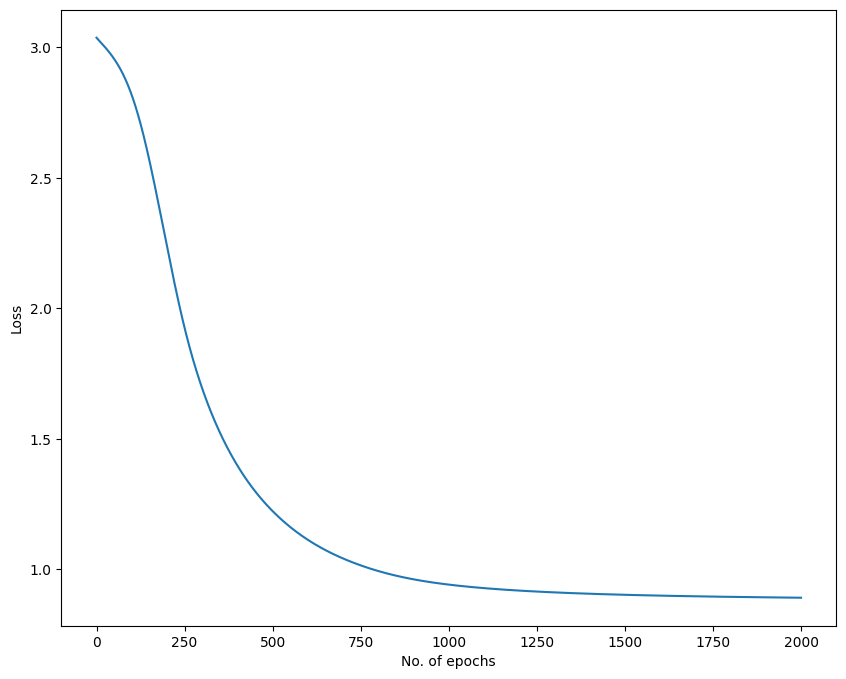

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss() # define loss func
loss_hist = [] # list to store loss values, to plot at the end

# <START>
# Initialize data and labels
train_data = get_input_tensor(torch.tensor(train_emb.Input.values), vocab_size) # Should be a one-hot encoded 2D tensor
train_labels = torch.tensor(train_emb.Output.values) #Should be a 1D tensor of the indexes of the neighbor words expected
# <END>

assert train_data.shape == (train_emb.shape[0], vocab_size)
assert train_labels.shape == (train_emb.shape[0],)
optimizer = torch.optim.SGD(skipgram_model.parameters(), lr=learning_rate)
for epo in range(num_epochs):
        # <START>
       # Compute predictions
  predictions=skipgram_model(train_data)
        # Compute loss
  loss=loss_fn(predictions, train_labels)
        # Reset gradients
  optimizer.zero_grad()
        # Backpropagation step
  loss.backward()
        # Update weights using gradient descent.
  optimizer.step()
        # <END>

  loss_hist.append(loss.item())

        # Print the loss every 250 epochs
  if epo%250 == 0:
    print(f'Epoch {epo}, loss = {loss}')

plt.plot(loss_hist)
plt.xlabel("No. of epochs")
plt.ylabel("Loss")

## **Using the Skip-Gram embedding**
By training the model to perform this fake task, we have now created a neural network that when given a one hot encoded from the vocabulary, reduces it to a vector of length `embed_dims`, and then tries to predict what words could be its neighbors.

What we are interested in, is the first part of this process - the reduction of a 21 long vector to one only 4 long.

We shall now extract the parameter responsible for this conversion - the weights of the first layer `W1`.

Access the tensor containing the weights of the first hidden layer, and create a "detached" copy of it, converted to a Numpy ndarray. Due to how PyTorch stores its weights, you will also have to transpose the matrix.

In [ ]:
# <START>
W1 = skipgram_model[0].weight.data.numpy().T

# <END>

assert isinstance(W1,np.ndarray) and W1.shape == (vocab_size,embed_dims)

You now have a matrix, that given a one hot word embedding, can map it to another embedding of lesser dimensions. You will see that the word embedding for a given index is very simply just the row of `W1` corresponding to said index.

$$
\begin{bmatrix}
0 & 1 & 0 & 0 &\cdots & 0
\end{bmatrix}_{1×V}
\times
\begin{bmatrix}
w^{1}_{1,1} & w^{1}_{1,2} &\cdots & w^{1}_{1,N}\\
w^{1}_{2,1} & w^{1}_{2,2} &\cdots & w^{1}_{2,N}\\
\vdots & \vdots &\ddots & \vdots\\
w^{1}_{V,1} & w^{1}_{V,2} &\cdots & w^{1}_{V,N}\\
\end{bmatrix}_{V×N}
=
\begin{bmatrix}
w^{1}_{2,1} & w^{1}_{2,2} &\cdots & w^{1}_{2,N}\\
\end{bmatrix}_{1×N}
$$
<br>
$$
\text{Here, V is vocab_size and N is embed_dims}
$$
> _Note: While the sizes remain the same, in Python everything is zero-indexed (first element is zero), not one-indexed like mathematical arrays. What you see here is the computation of the one-hot vector corresponding to index 1 in Python_

### **Graphical Representation**

We now wish to observe the similarities and relations between the generated word embeddings, and the simplest way to do so is graphically. However, we cannot easily represent a complete 4D vector in a graph.

To solve this, we shall use **SVD (Single Value Decomposition)** to reduce the $21\times4$ matrix to a $21\times2$ matrix, containing only the **most sailent features** of the matrix.

You need not understand this concept however, and all you need to know is that **in exchange for reducing the number of features of our word we care about, we are able to represent the embedding in even lesser dimensions.**  
Note however, that it **may not always be** that the **reduction in features** must also lead to **a reduction in quality and usability**, as you shall see.

<details>
  <summary>Resources on SVD (Optional)</summary>
  <ul>
  <li><a href = "http://timbaumann.info/svd-image-compression-demo/">Short article with demo of usage in image compression</a></li>
  <li><a href = "https://www.youtube.com/watch?v=OvzJiur55vo">Youtube video on application in NLP</a></li>
  </ul>
</details>

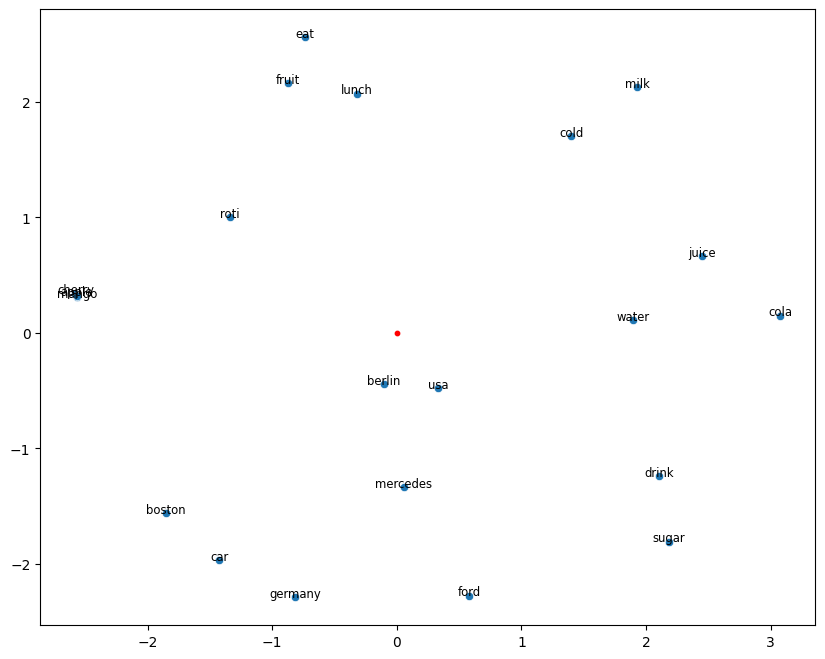

In [ ]:
svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1) #Now a 21 x 2 matrix

# Just like we saw in the original W1, each row is
# a word embedding, i.e a given column contains the
# components of every word embedding along a certain "direction"
x = W1_dec[:,0]
y = W1_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

# Red dot on the origin
plot.scatter(x=0, y=0, color='r',s=10)

for i in range(0,W1_dec.shape[0]):
     plot.text(x[i], y[i], list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='normal');


You should see one very closely arranged group of similar words, along with one or more slightly dispersed yet clearly and separately visible groups of similar words (how separate they are could change if you have changed the hyper-parameters).
### **Comparing quantitatively using Cosine Similarity**

To better understand how closely related any two words our, we shall use a simple metric called **cosine similarity**.

Just like in the vector algebra you know, the smaller the angle between two vectors, the larger the value of its cosine will be. Therefore, by finding the cosine of the angle between two word embeddings, we can compare how similar they are.

First, complete the function `get_embeddings`, that for a given word, returns the corresponding 4D and 2D word embeddings. `cosine_similarity` will not accept rank one arrays, make sure the array is "2D" (in a different sense than the word embeddings).

In [ ]:
def get_embeddings(word):
  # <START>
  # Get the 4D and 2D representations corresponding to the word
  # using vocabulary, W1 and W1_dec
  idx = vocabulary[word]
  m=get_one_hot(idx, vocab_size)
  vec_4d = np.matmul(m,W1)
  vec_2d = np.matmul(m,W1_dec)

  # <END>
  return vec_4d,vec_2d


Try checking out the similarity of words in both 4D and 2D word embeddings.

In [ ]:
# <START>
word1 = 'cherry'
word2 = 'apple'
# <END>

assert vocabulary[word1] != None and vocabulary[word2] != None

word1_4d, word1_2d = get_embeddings(word1)
word2_4d, word2_2d = get_embeddings(word2)

print(f'Cosine similarity of {word1} and {word2}:')
print('4D: {:.3f}'.format(cosine_similarity(word1_4d,word2_4d)[0,0]))
print('2D: {:.3f}'.format(cosine_similarity(word1_2d,word2_2d)[0,0]))

Cosine similarity of cherry and apple:
4D: 1.000
2D: 1.000
